In [17]:
import numpy as np
import pandas as pd
import scipy.io as scp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import xlsxwriter 
import scipy as scy
from PIL import Image
plt.style.use('seaborn-paper')
plt.rc('text',usetex=True)
%matplotlib inline

In [2]:
data = pd.read_excel('Calib_no_silent_one_rep.xlsx',index_col = [0])

In [3]:
data.shape

(40, 657)

In [4]:
from sklearn.model_selection import KFold,train_test_split
from itertools import chain, repeat
from sklearn.metrics import r2_score,mean_squared_error
from scipy import signal
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin

In [5]:
class MCR_ALS(BaseEstimator,RegressorMixin):
    
    def __init__(self,ST = None,calibration_concentrations = None,D = None,concentrations = None,tol = None,maxiter = None):
        
        self.tolerance = tol
        self.max_iters = maxiter
        self.lof = None
        self.ST = ST
        self.D = D
        self.C = None
        self.concentrations = concentrations
        self.calibration_concentrations = calibration_concentrations
        self.predictions = None
        
    def predict(self,D,calibration_concentrations,maxiter,tol):
        
        self.max_iters = maxiter
        self.tolerance = tol
        lof_found_vect = [0]
        lof_found  = 0
        iters=0
        self.D_hat = D
        self.D = D
        self.C = self.D_hat@np.linalg.pinv(self.ST)
        
        while (iters<self.max_iters):
            iters+=1
            self.C = self.D_hat@np.linalg.pinv(self.ST) #MCR ALS 
            self.ST = (np.linalg.pinv(self.C)@self.D_hat)
            self.D_hat = self.C@self.ST     #Recalculate mixtures matrix 
            lof = 100*np.sqrt(abs(np.sum((D-self.D_hat)**2)/(np.sum(self.D_hat**2))))
            if lof < self.tolerance:
                lof_found_vect.append(1)
            else:
                lof_found_vect.append(0)

            lof_found = lof_found_vect[-1]+lof_found_vect[-2]
            
            if ((lof_found==2)):
                break
                print('Non-negative convergence achieved')
            
        self.lof = lof
        print('Lack of fit {}'.format(lof))
        print('Number of iterations completed {}'.format(iters))
        
        self.predictions = self.C@calibration_concentrations
        self.predictions[self.predictions < 0] = 0
        self.C[self.C < 0] = 0
        
        return self.predictions
        
    def fit(self,ST):
        self.ST = ST
        
    def score(self,concentrations,calibration_concentrations):
        self.concentrations = concentrations
        self.calibration_concentrations = calibration_concentrations
      
    def RMSE(self):
        assert self.predictions.shape[0] == self.D.shape[0]
        self.RMSE = np.sqrt(mean_squared_error(self.concentrations,self.predictions))
        return self.RMSE
    
    def R2(self):
        assert self.predictions.shape[0] == self.D.shape[0]
        return [r2_score(self.concentrations,self.predictions),\
                r2_score(self.concentrations[:,0],self.predictions[:,0]),\
                r2_score(self.concentrations[:,1],self.predictions[:,1]),\
               r2_score(self.concentrations[:,2],self.predictions[:,2])]
        

In [6]:
#Make sure everything works
#Split the data set 
y = data.iloc[:,:3]
X = data.iloc[:,3:]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=1)


In [7]:
model = MCR_ALS()

In [8]:
model.fit(X_train.values)

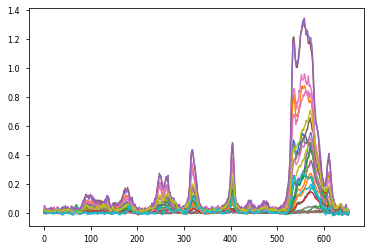

In [9]:
plt.plot(X_train.values.T);

In [10]:
model.predict(D = X_test.values,calibration_concentrations=y_train.values,maxiter = 5000,tol = 0.01)

Lack of fit 1.1691211234628066e-13
Number of iterations completed 2


array([[0.00000000e+00, 5.42058201e+00, 1.74479810e+01],
       [3.72509475e+01, 4.21916197e+01, 3.85973203e+00],
       [0.00000000e+00, 5.07783636e+01, 3.33685455e+01],
       [7.91734836e-01, 0.00000000e+00, 9.22116101e+00],
       [8.49170569e+00, 0.00000000e+00, 3.14912133e-01],
       [3.53491565e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.15187097e+01],
       [3.25541376e+01, 1.79430244e+01, 3.72398903e+01],
       [0.00000000e+00, 2.71213846e+02, 3.11722934e+00],
       [0.00000000e+00, 1.48792494e-02, 4.43123997e-01]])

In [11]:
y_test

,DNA,Protein,Lipid
2,0,10.0,10
31,50,61.0,0
3,0,50.0,25
21,0,0.0,5
27,10,0.0,0
29,40,0.0,0
22,0,0.0,10
39,28,10.0,60
19,0,300.0,0
26,0,0.0,0


In [12]:
model.score(y_test.values,y_train.values)

In [13]:
model.RMSE()

8.492034822123294

In [14]:
model.R2()

[0.9030297701937496,
 0.9378853870760068,
 0.9837231907587423,
 0.7874807327464999]

# MCR-ALS Xval

In [15]:
#10-fold Cross validation
num_folds = 10

Lack of fit 1.3981321401404794e-13
Number of iterations completed 2
Lack of fit 2.611757175574997e-13
Number of iterations completed 2
Lack of fit 1.771793910140581e-13
Number of iterations completed 2
Lack of fit 5.925302162542675e-14
Number of iterations completed 2
Lack of fit 5.11781493216939e-14
Number of iterations completed 2
Lack of fit 7.404993779850369e-14
Number of iterations completed 2
Lack of fit 3.829139367206416e-14
Number of iterations completed 2
Lack of fit 1.517902460384367e-13
Number of iterations completed 2
Lack of fit 9.263943843525087e-14
Number of iterations completed 2
Lack of fit 4.0161808603017024e-13
Number of iterations completed 2


CV RMSE: 7.76812669355179
CV R2: 0.9373776151402389
DNA CV RMSE: 3.154075922686076
DNA CV R2: 0.9648659124673398
Protein CV RMSE: 8.445379670217541
Protein CV R2: 0.9834666877552671
Lipid CV RMSE: 9.987929929721366
Lipid CV R2: 0.8638002451981096


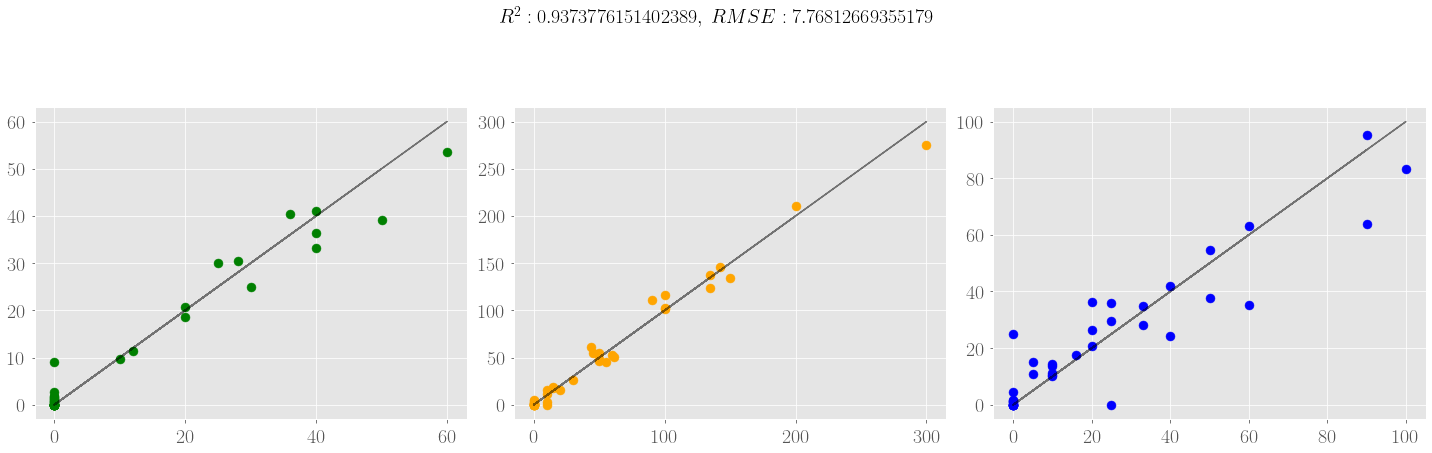

In [18]:
model = MCR_ALS()

y= data.iloc[:,:3]
X = data.iloc[:,3:]

# Split data into training/test sets
kf = KFold(n_splits=num_folds, shuffle=True,random_state = 4)
kf.get_n_splits(data)
 
RMSE_list = []
R2_list = []

predictions = np.empty((0,3))
ground_truths = np.empty((0,3))

for train_index, test_index in kf.split(data):
    #Xval data
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    y_train = y.iloc[train_index,:]
    y_test = y.iloc[test_index,:]

    model.fit(X_train.values)
    predictions = np.concatenate((predictions,\
                model.predict(D = X_test.values,calibration_concentrations=y_train.values,maxiter = 5000,tol = 0.01)))
    ground_truths = np.concatenate((ground_truths,y_test.values))
    model.score(y_test.values,y_train.values)
    

#Overall metrics
RMSE = np.sqrt(mean_squared_error(ground_truths,predictions))
R2 = r2_score(ground_truths,predictions)

RMSE_DNA = np.sqrt(mean_squared_error(ground_truths[:,0],predictions[:,0]))
R2_DNA = r2_score(ground_truths[:,0],predictions[:,0])

RMSE_Prot = np.sqrt(mean_squared_error(ground_truths[:,1],predictions[:,1]))
R2_Prot = r2_score(ground_truths[:,1],predictions[:,1])

RMSE_Lipid = np.sqrt(mean_squared_error(ground_truths[:,2],predictions[:,2]))
R2_Lipid = r2_score(ground_truths[:,2],predictions[:,2])

print('\n')
print('CV RMSE:',RMSE)
print('CV R2:',R2)
print('DNA CV RMSE:',RMSE_DNA)
print('DNA CV R2:',R2_DNA)
print('Protein CV RMSE:',RMSE_Prot)
print('Protein CV R2:',R2_Prot)
print('Lipid CV RMSE:',RMSE_Lipid)
print('Lipid CV R2:',R2_Lipid)

with plt.style.context(('ggplot')):
    fig,ax = plt.subplots(nrows = 1,ncols = 3, figsize = (20,5))
    ax = ax.ravel()
    ax[0].scatter(ground_truths[:,0],predictions[:,0],color = 'green',label = 'DNA',s=80)
    ax[1].scatter(ground_truths[:,1],predictions[:,1],color ='orange',label = 'Protein',s=80)
    ax[2].scatter(ground_truths[:,2],predictions[:,2],color ='blue',label = 'Lipid',s=80)
    ax[0].plot(ground_truths[:,0],ground_truths[:,0],color ='black',alpha = .5)
    ax[1].plot(ground_truths[:,1],ground_truths[:,1],color ='black',alpha = .5)
    ax[2].plot(ground_truths[:,2],ground_truths[:,2],color ='black',alpha = .5)
    
    ax[0].tick_params(labelsize=20)
    ax[1].tick_params(labelsize=20)
    ax[2].tick_params(labelsize=20)
    
    ax[0].locator_params(axis='x',nbins=4)
    ax[1].locator_params(axis='x',nbins=4)
    ax[2].locator_params(axis='x',nbins=6)
    plt.tight_layout()
    
    fig.suptitle('$R^{2}: '+str(R2)+', \: RMSE:'+np.str(RMSE)+'$',fontsize=20,y=1.25)
    fig.savefig('MRC-ALS.jpeg',dpi=300)

# PCA

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
PCA_model = PCA()
PCA_model1 = PCA()
Scaler = StandardScaler()
scaled_data = Scaler.fit_transform(X = X_train.values)
PCA_model.fit_transform(X = scaled_data );
PCA_model1.fit_transform(X = X_train.values);

Text(0.5, 1.0, 'Scaled')

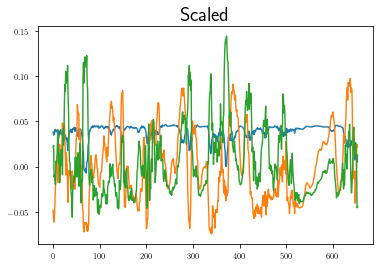

In [21]:
plt.plot(PCA_model.components_[:3,:].T)
plt.title('Scaled',fontsize = 20)

Text(0.5, 1.0, 'Unscaled')

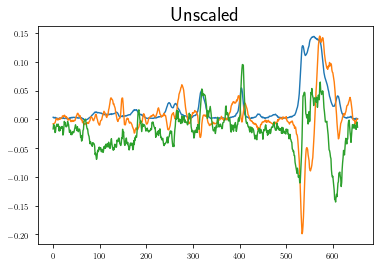

In [22]:
plt.plot(PCA_model1.components_[:3,:].T)
plt.title('Unscaled',fontsize = 20)

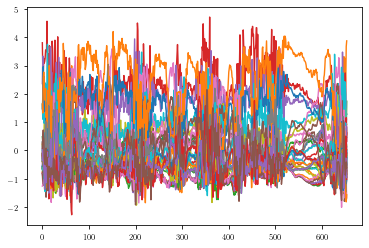

In [23]:
plt.plot(scaled_data.T);

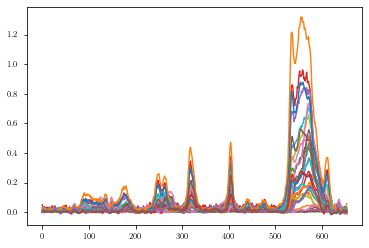

In [24]:
plt.plot(X_train.values.T);

# NMF

In [25]:
from sklearn.decomposition import NMF

In [26]:
NMF_model = NMF(n_components=3)

In [27]:
NMF_model.fit(abs(X_train.values))

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=3, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

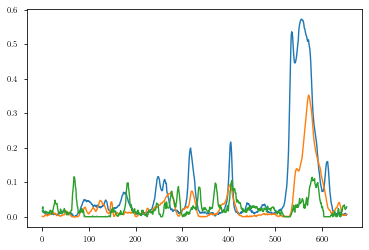

In [28]:
plt.plot(NMF_model.components_.T);

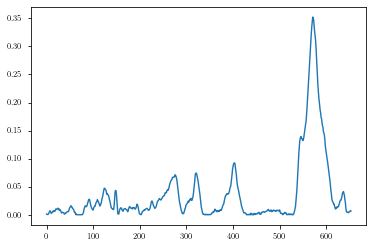

In [29]:
plt.plot(NMF_model.components_.T[:,1]);